# Efecto de distintos valores de learning rate $\alpha$

El valor del learning rate $\alpha$ determina la velocidad de aprendizaje. Si recordamos los parámetros se modificaban mediante la siguiente fórmula

$$\omega_i' = \omega_i - \alpha\frac{\partial loss}{\partial \omega_i}$$

Es decir el peso de la red se modifica restándole el gradiente de la función de coste multiplicado por el learning rate $\alpha$. Por lo que modificar este valor va a hacer que se modifique más o menos el valor del peso, es decir, que la red aprenda más o menos deprisa

Vamos e ver este efecto en el primer ejemplo de entrenamiento que vimos

Supongamos que tenemos la siguiente distribución de puntos

In [1]:
import numpy as np

x = np.array( [ 0.        ,  0.34482759,  0.68965517,  1.03448276,  1.37931034,
        1.72413793,  2.06896552,  2.4137931 ,  2.75862069,  3.10344828,
        3.44827586,  3.79310345,  4.13793103,  4.48275862,  4.82758621,
        5.17241379,  5.51724138,  5.86206897,  6.20689655,  6.55172414,
        6.89655172,  7.24137931,  7.5862069 ,  7.93103448,  8.27586207,
        8.62068966,  8.96551724,  9.31034483,  9.65517241, 10.        ])

y = np.array( [-0.16281253,  1.88707606,  0.39649312,  0.03857752,  4.0148778 ,
        0.58866234,  3.35711859,  1.94314906,  6.96106424,  5.89792585,
        8.47226615,  3.67698542, 12.05958678,  9.85234481,  9.82181679,
        6.07652248, 14.17536744, 12.67825433, 12.97499286, 11.76098542,
       12.7843083 , 16.42241036, 13.67913705, 15.55066478, 17.45979602,
       16.41982806, 17.01977617, 20.28151197, 19.38148414, 19.41029831])

Los representamos

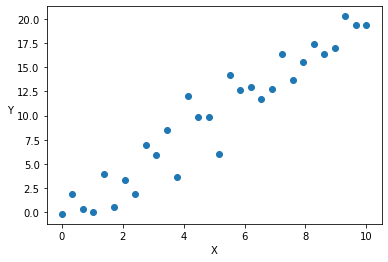

In [2]:
import matplotlib.pyplot as plt

plt.scatter(x, y)
plt.xlabel('X')
plt.ylabel('Y  ', rotation=0)
plt.show()

Queremos crear una red neuronal que se ajuste a esos puntos, así que hacemos todo el proceso

## Dataset y Dataloader

Creamos un dataset

In [3]:
import torch

class Dataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = torch.from_numpy(x).type(torch.float32).reshape((len(x), 1))
        self.y = torch.from_numpy(y).type(torch.float32).reshape((len(y), 1))

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [4]:
dataset = Dataset(x, y)

x.shape, y.shape, len(dataset)

((30,), (30,), 30)

In [5]:
sample = dataset[0]
x_sample, y_sample = sample

x_sample.dtype, y_sample.dtype

(torch.float32, torch.float32)

In [6]:
from torch.utils.data import DataLoader

BS = 4

dataloader = DataLoader(dataset, batch_size=BS)

In [7]:
batch = next(iter(dataloader))
sample_x, sample_y = batch
sample_x.shape, sample_y.shape

(torch.Size([4, 1]), torch.Size([4, 1]))

## Red neuronal

In [12]:
from torch import nn

class Model(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super().__init__()
        self.layer = torch.nn.Linear(num_inputs, num_outputs, bias=False)

    def forward(self, x):
        logits = self.layer(x)
        return logits

In [13]:
num_inputs = 1
num_outputs = 1
model = Model(num_inputs, num_outputs)

model

Model(
  (layer): Linear(in_features=1, out_features=1, bias=False)
)

In [15]:
for name, param in model.named_parameters():
    print(f"Capa: {name} | Size: {param.size()} | Value : {param[:2]} \n")

Capa: layer.weight | Size: torch.Size([1, 1]) | Value : tensor([[-0.2244]], grad_fn=<SliceBackward>) 



In [16]:
logits = model(sample_x)
logits.shape

torch.Size([4, 1])

In [17]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

model.to(device)

Using cuda device


Model(
  (layer): Linear(in_features=1, out_features=1, bias=False)
)

## Función de pérdida y optimizador

In [18]:
LR = 1e-3

loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)

## Ciclo de entrenamiento

In [19]:
num_prints = 4

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    
    for batch, (X, y) in enumerate(dataloader):
        # X and y to device
        X, y = X.to(device), y.to(device)

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % int(len(dataloader)/(num_prints-1)) == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [20]:
epochs = 14
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(dataloader, model, loss_fn, optimizer)
print("Done!")

Epoch 1
-------------------------------
loss: 1.065680  [    0/   30]
loss: 51.217781  [    8/   30]
loss: 178.792908  [   16/   30]
loss: 233.358154  [   24/   30]
Epoch 2
-------------------------------
loss: 0.824169  [    0/   30]
loss: 15.990150  [    8/   30]
loss: 56.403248  [   16/   30]
loss: 66.892082  [   24/   30]
Epoch 3
-------------------------------
loss: 1.068729  [    0/   30]
loss: 7.140075  [    8/   30]
loss: 20.579899  [   16/   30]
loss: 20.434147  [   24/   30]
Epoch 4
-------------------------------
loss: 1.297140  [    0/   30]
loss: 5.115815  [    8/   30]
loss: 9.517916  [   16/   30]
loss: 7.187534  [   24/   30]
Epoch 5
-------------------------------
loss: 1.443731  [    0/   30]
loss: 4.765315  [    8/   30]
loss: 5.822448  [   16/   30]
loss: 3.267590  [   24/   30]
Epoch 6
-------------------------------
loss: 1.527668  [    0/   30]
loss: 4.774450  [    8/   30]
loss: 4.459370  [   16/   30]
loss: 2.036445  [   24/   30]
Epoch 7
----------------------

## Resultado

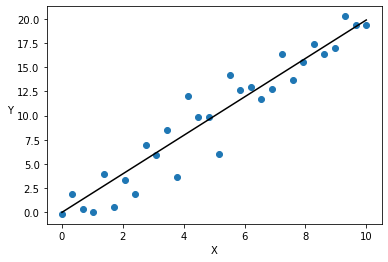

In [30]:
x_tensor = torch.from_numpy(x).type(torch.float32).reshape((len(x), 1))
model.to("cpu")
z = model(x_tensor).detach().numpy()
x_tensor.shape, z.shape

plt.scatter(x, y)
plt.plot(x, z, 'k')
plt.xlabel('X')
plt.ylabel('Y  ', rotation=0)
plt.show()

## Varios LR

Volvemos a crear la red neuronal desde cero y probamos a entrenarla con varios LRs

In [31]:
LRs = [1e-3, 1e-5, 1e-1]

In [93]:
def entrenamiento(epochs, dataloader, model, loss_fn, optimizer):
    Zs = np.empty((epochs, len(x), 1))
    for e in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(dataloader, model, loss_fn, optimizer)
        Zs[e] = model(x_tensor.to(device)).to("cpu").detach().numpy()
    print("Done!")
    
    return Zs

In [94]:
import copy

model = Model(num_inputs, num_outputs)
Zs = np.empty((len(LRs), epochs, len(x), 1))
epochs = 14

for i, LR in enumerate(LRs):
    # Se copia la red neuronal original y se manda a la GPU
    model_copy = copy.deepcopy(model).to(device)

    # Se define el optimizador
    optimizer = torch.optim.SGD(model_copy.parameters(), lr=LR)

    # Se entrena la red
    model_copy.to(device)
    entrenamiento(epochs, dataloader, model_copy, loss_fn, optimizer)

    # Se mueve la red neuronal entrenada a la CPU
    model_copy.to("cpu")

    # Se obtiene el logits de la red neuronal entrenada
    logits = model_copy(x_tensor).detach().numpy()
    Zs[i] = logits

Epoch 14
-------------------------------
loss: 0.818341  [    0/   30]
loss: 16.636269  [    8/   30]
loss: 58.818615  [   16/   30]
loss: 70.101120  [   24/   30]
Epoch 14
-------------------------------
loss: 1.058632  [    0/   30]
loss: 7.295704  [    8/   30]
loss: 21.306252  [   16/   30]
loss: 21.339176  [   24/   30]
Epoch 14
-------------------------------
loss: 1.289952  [    0/   30]
loss: 5.147630  [    8/   30]
loss: 9.751597  [   16/   30]
loss: 7.450385  [   24/   30]
Epoch 14
-------------------------------
loss: 1.439459  [    0/   30]
loss: 4.768477  [    8/   30]
loss: 5.904832  [   16/   30]
loss: 3.347764  [   24/   30]
Epoch 14
-------------------------------
loss: 1.525298  [    0/   30]
loss: 4.772444  [    8/   30]
loss: 4.491592  [   16/   30]
loss: 2.062774  [   24/   30]
Epoch 14
-------------------------------
loss: 1.572211  [    0/   30]
loss: 4.829415  [    8/   30]
loss: 3.915859  [   16/   30]
loss: 1.625162  [   24/   30]
Epoch 14
--------------------

In [95]:
Zs.shape, Zs[0].shape

((3, 14, 30, 1), (14, 30, 1))

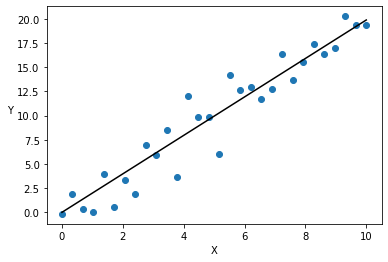

In [74]:
plt.scatter(x, y)
plt.plot(x, Zs[0], 'k')
plt.xlabel('X')
plt.ylabel('Y  ', rotation=0)
plt.show()

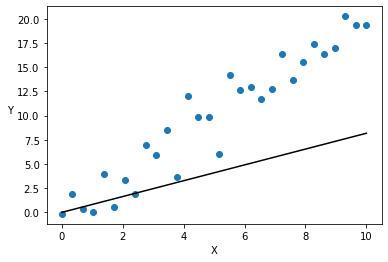

In [75]:
plt.scatter(x, y)
plt.plot(x, Zs[1], 'k')
plt.xlabel('X')
plt.ylabel('Y  ', rotation=0)
plt.show()

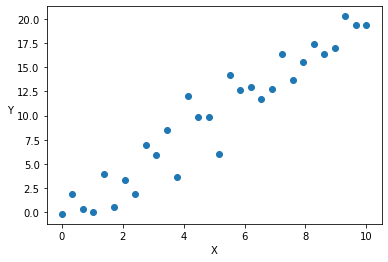

In [76]:
plt.scatter(x, y)
plt.plot(x, Zs[2], 'k')
plt.xlabel('X')
plt.ylabel('Y  ', rotation=0)
plt.show()